In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import requests

from astropy.io import ascii
from astropy.time import Time

In [3]:
def SHARequest(ra, dec, size=0.2, verb=3):
    """
    Retrieve all Spitzer observations by ra and dec in degrees. 
    """
    request_url = "http://sha.ipac.caltech.edu/applications/Spitzer/SHA/servlet/DataService"
    params = {"RA": ra, 
              "DEC": dec, 
              "SIZE": size, 
              "VERB": verb, 
              "DATASET": "ivo://irsa.ipac/spitzer.level2"}
    output = requests.get(request_url, params=params)
    tbl = ascii.read(output.text, format='ipac')
    return tbl

In [4]:
## read in all AOR keys from SPIRITS
spirits_lookup = set()
for filename in ["spirits10.tbl", "spirits11.tbl", "spirits13.tbl"]:
    tbl = ascii.read(filename, format="ipac")
    for row in tbl:
        spirits_lookup.add(row["AORKEY"])

In [5]:
## a help function to calculate time difference in days
def time_diff(strtime1, strtime2):
    dt = Time(strtime1) - Time(strtime2)
    return abs(dt.jd)

In [13]:
## S means spirits epoch
## A means archival epoch
res = {"IRAC 3.6um": {"S-S": list(),
                      "S-A": list(),
                      "A-A": list()
                     },
       "IRAC 4.5um": {"S-S": list(),
                      "S-A": list(),
                      "A-A": list()
                     }
      }

cnt = 0
with open("spirits_galaxies.txt", "r") as fp:
    for row in fp:
        items = row.split()
        name = items[0]
        if name.startswith("LMC"):
            continue
        print "Proccessing Galaxy %s" % name
        ra = float(items[1])
        dec = float(items[2])
        tbl = SHARequest(ra, dec)
        tbl.sort(keys="reqkey")
        for key in res:
            # remove repeating AORs
            i = 0
            tmp_tbl = []
            while i < len(tbl):
                if tbl[i]["wavelength"] != key:
                    i += 1
                    continue
                tmp_tbl.append((tbl[i]["reqkey"], tbl[i]["begintime"]))
                i += 1
                while i < len(tbl) and time_diff(tbl[i]["begintime"], tbl[i - 1]["begintime"]) < 0.7:
                        i += 1
            for i in range(len(tmp_tbl) - 1):
                aor_key_i, obstime_i = tmp_tbl[i]
                for j in range(i + 1, len(tmp_tbl)):
                    aor_key_j, obstime_j = tmp_tbl[j]
                    k = (aor_key_i in spirits_lookup) + (aor_key_j in spirits_lookup)
                    if k == 0:
                        pair_type = "A-A"
                    elif k == 1:
                        pair_type = "S-A"
                    else:
                        pair_type = "S-S"
                    res[key][pair_type].append(time_diff(obstime_i, obstime_j))

Proccessing Galaxy CentaurusA
Proccessing Galaxy ESO121G006
Proccessing Galaxy ESO209G009
Proccessing Galaxy ESO270G017
Proccessing Galaxy ESO274G001
Proccessing Galaxy ESO494G026
Proccessing Galaxy FornaxDwarfSpheroidal
Proccessing Galaxy HolmbergII
Proccessing Galaxy IC0342
Proccessing Galaxy IC1613
Proccessing Galaxy IC2163
Proccessing Galaxy IC2233
Proccessing Galaxy IC2574
Proccessing Galaxy IC5152
Proccessing Galaxy IC5201
Proccessing Galaxy LeoI
Proccessing Galaxy Maffei1
Proccessing Galaxy MESSIER032
Proccessing Galaxy MESSIER049
Proccessing Galaxy MESSIER051a
Proccessing Galaxy MESSIER051b
Proccessing Galaxy MESSIER058
Proccessing Galaxy MESSIER059
Proccessing Galaxy MESSIER060
Proccessing Galaxy MESSIER061
Proccessing Galaxy MESSIER063
Proccessing Galaxy MESSIER064
Proccessing Galaxy MESSIER065
Proccessing Galaxy MESSIER066
Proccessing Galaxy MESSIER074
Proccessing Galaxy MESSIER081
Proccessing Galaxy MESSIER082
Proccessing Galaxy MESSIER083
Proccessing Galaxy MESSIER084
Proc

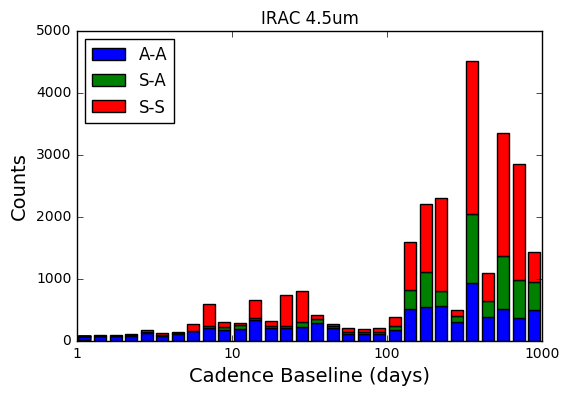

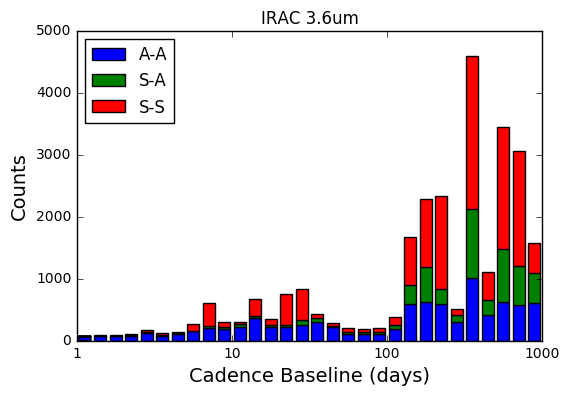

In [14]:
for key in res:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    bins = np.linspace(0, 3, 31)
    data = [np.log10(np.array(res[key]["A-A"])),
            np.log10(np.array(res[key]["S-A"])),
            np.log10(np.array(res[key]["S-S"]))]
    labels = ["A-A", "S-A", "S-S"]
    ax.hist(data, bins=bins, stacked=True, label=labels)
    ax.set_xlabel("Cadence Baseline (days)", fontsize=14)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(["1", "10", "100", "1000"])
    ax.set_ylabel("Counts", fontsize=14)
    ax.legend(loc="upper left")
    ax.set_title(key)